In [4]:
import torch
import einops

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import itertools

from utils.components import *
from utils.config import *
from utils.einmask import EinMask
from utils.dataset import NinoData

from utils.masking import *

from omegaconf import OmegaConf
from dataclasses import replace

import torch_harmonics

In [5]:
cfg_file = OmegaConf.load('mae.yaml')
config = MTMConfig.from_omegaconf(cfg_file['defaults'])

In [6]:
from utils.random_fields import SphericalDiffusionNoise

In [7]:
kts = np.array([3.08*1e-5, 1.23*1e-4, 4.93*1e-4, 1.97*1e-3, 7.89*1e-3, 3.16*1e-2, 0.126, 0.505])

In [19]:
kts

array([3.08e-05, 1.23e-04, 4.93e-04, 1.97e-03, 7.89e-03, 3.16e-02,
       1.26e-01, 5.05e-01])

In [35]:
h = [100 * 2**a for a in torch.linspace(2, 6, 5)]

In [36]:
h

[tensor(400.), tensor(800.), tensor(1600.), tensor(3200.), tensor(6400.)]

In [37]:
dn = SphericalDiffusionNoise(len(h), temporal_length=3, horizontal_length = h, num_steps= 24)
dn = dn.to('cuda')

In [38]:
state = dn((16,)).cpu()
state = einops.reduce(state, '... (h hh) (w ww) -> ... h w', hh=4, ww=4, reduction='mean')

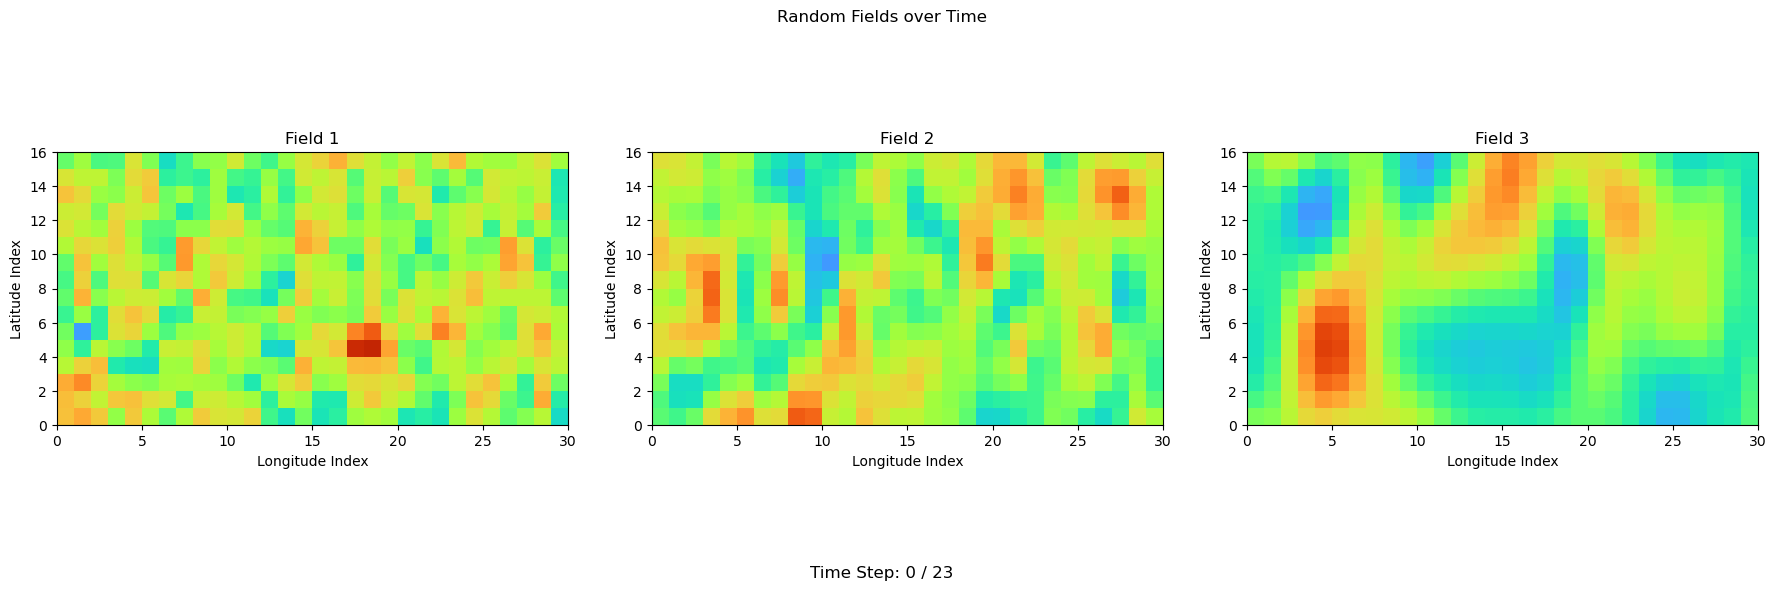

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

num_fields = 3

x = np.linspace(0, state.size(-1))
y = np.linspace(0, state.size(-2))
X, Y = np.meshgrid(x, y)
T = np.linspace(0, state.size(-3))

state_to_animate = state.numpy()[0, :num_fields]

fig, axes = plt.subplots(1, num_fields, figsize=(6 * num_fields, 6)) 
plt.suptitle('Random Fields over Time')

plots = []
v_min_global = state_to_animate.min()
v_max_global = state_to_animate.max()

for i in range(num_fields):
    ax = axes[i]

    mesh = ax.pcolormesh(
        state_to_animate[i, 0, :, :],
        vmin=v_min_global,
        vmax=v_max_global,
        shading='auto',
        cmap='turbo'
    )
    ax.set_title(f'Field {i+1}')
    ax.set_xlabel('Longitude Index')
    ax.set_ylabel('Latitude Index')
    ax.set_aspect('equal', adjustable='box') # Keep the spatial aspect ratio 
    
    plots.append(mesh)

time_text = fig.text(0.5, 0.04, f'Time Step: 0 / {dn.nsteps - 1}', 
                     ha='center', va='center', fontsize=12)


def update(frame):
    for i in range(num_fields):
       data = state_to_animate[i, frame, :, :]
       plots[i].set_array(data)
        
    time_text.set_text(f'Time Step: {frame} / {dn.nsteps - 1}')
    return plots + [time_text] 

ani = FuncAnimation(
    fig, 
    update, 
    frames=state.size(-3), 
    interval=400, 
    blit=False,
    repeat=True 
)

plt.tight_layout(rect=[0, 0.08, 1, 1]) 

In [44]:
HTML(ani.to_jshtml())

In [ ]:
from einops.layers.torch import EinMix
import einops

In [ ]:
nemb = EinMix('b k (t tt) (h hh) (w ww) -> b (v t h w) d', 
              weight_shape= 'v k tt hh ww d',  
              hh = 4, ww= 4, tt = 6, v = 5, k = num_fields, d = 512)

In [ ]:
nemb(state).shape

torch.Size([1, 14400, 512])

In [ ]:
nemb.weight.numel()

737280

In [ ]:
def xr_pcc(pred: xr.DataArray, obs: xr.DataArray, dim: tuple[str]):
        num = (pred * obs).sum(dim)
        denom = np.sqrt((pred**2).sum(dim)) * np.sqrt((obs**2).sum(dim))
        return num / denom

In [ ]:
ds = NinoData(config.trainer.godas_path, config.data)

In [ ]:
ds.dataset.lon

<xarray.DataArray 'lon' (lon: 120)> Size: 960B
array([ 90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108., 110., 112.,
       114., 116., 118., 120., 122., 124., 126., 128., 130., 132., 134., 136.,
       138., 140., 142., 144., 146., 148., 150., 152., 154., 156., 158., 160.,
       162., 164., 166., 168., 170., 172., 174., 176., 178., 180., 182., 184.,
       186., 188., 190., 192., 194., 196., 198., 200., 202., 204., 206., 208.,
       210., 212., 214., 216., 218., 220., 222., 224., 226., 228., 230., 232.,
       234., 236., 238., 240., 242., 244., 246., 248., 250., 252., 254., 256.,
       258., 260., 262., 264., 266., 268., 270., 272., 274., 276., 278., 280.,
       282., 284., 286., 288., 290., 292., 294., 296., 298., 300., 302., 304.,
       306., 308., 310., 312., 314., 316., 318., 320., 322., 324., 326., 328.])
Coordinates:
  * lon       (lon) float64 960B 90.0 92.0 94.0 96.0 ... 322.0 324.0 326.0 328.0
    variable  <U12 48B 'temp_ocn_0a'

In [ ]:
nino34 = ds.dataset['temp_ocn_0a'].sel(lon=slice(160, 210), lat=slice(-5, 5)).mean(dim=['lon', 'lat'])#.rolling(time = 3).mean()
nino34_smooth = ds.dataset['temp_ocn_0a'].sel(lon=slice(160, 210), lat=slice(-5, 5)).mean(dim=['lon', 'lat']).rolling(time = 3).mean()

In [ ]:
ls = np.linspace(0,1, 11)
id = np.argwhere(ls > 0.5).max(initial= 0)
print(float(id))

10.0


In [ ]:
pcc = xr_pcc(ds.dataset['temp_ocn_0a'], ds.dataset['temp_ocn_0a'].rolling(time=3).mean(), 'time')

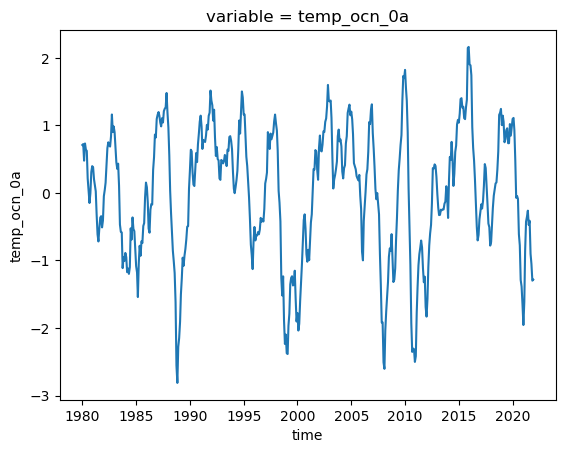

In [ ]:
nino34.plot()

In [ ]:
ds.dataset

<xarray.Dataset> Size: 155MB
Dimensions:       (time: 504, lat: 64, lon: 120)
Coordinates:
  * time          (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2021-12-01
  * lat           (lat) float64 512B -31.0 -30.0 -29.0 -28.0 ... 30.0 31.0 32.0
  * lon           (lon) float64 960B 90.0 92.0 94.0 96.0 ... 324.0 326.0 328.0
    month         (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
    variable      <U12 48B 'temp_ocn_0a'
Data variables:
    temp_ocn_0a   (time, lat, lon) float64 31MB 0.9376 0.8365 ... 0.08766 0.1493
    temp_ocn_3a   (time, lat, lon) float64 31MB 1.826 1.918 ... -0.01389 0.05493
    temp_ocn_8a   (time, lat, lon) float64 31MB 1.047 1.032 ... 0.1945 0.3425
    temp_ocn_14a  (time, lat, lon) float64 31MB 2.268 2.347 ... -0.1503 0.0379
    tauxa         (time, lat, lon) float64 31MB -0.1726 -0.2267 ... 0.2099

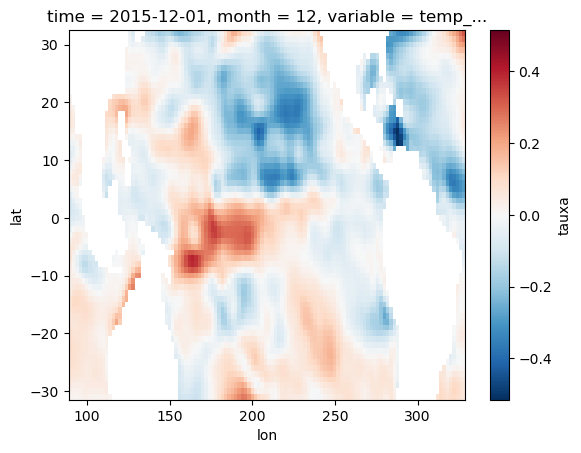

In [ ]:
ds.dataset['tauxa'].sel(time='2015-12-01').plot()

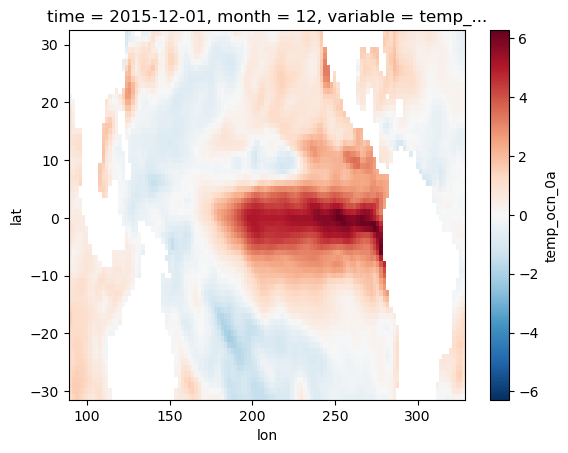

In [ ]:
ds.dataset['temp_ocn_0a'].sel(time='2015-12-01').plot()